In [1]:
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image, ImageFilter
import math
from os import listdir
import random
import cv2

import pywt

import keras
from keras import backend as K
from keras.models import model_from_json
from keras.models import Model, Sequential
from keras.layers import Input, Convolution2D, Conv2D, MaxPooling2D, Dense, Dropout, Flatten, Conv2D, BatchNormalization, GlobalAveragePooling2D
from keras.callbacks import LearningRateScheduler
from keras.optimizers import SGD, Adam
from keras import regularizers, optimizers, losses, initializers

import tensorflow as tf
from tensorflow.python.client import device_lib

import skimage
from skimage import measure

from PIL import Image

Using TensorFlow backend.


In [2]:
from srcnn import *
from utility import *

%matplotlib inline

In [3]:
#Division by 4
window_size= 64
scale = 4
stride = 16

In [4]:
def calcPSNR(original,prediction):
    return measure.compare_psnr(original, prediction,data_range=256)

In [5]:
def calcSSIM(orig,pred):
    return measure.compare_ssim(orig,pred,data_range=256)

In [6]:
def calcMSE(orig,pred):
    return measure.compare_mse(orig,pred)

In [7]:
#Returns original, bicubic and model prediction
def getImages(filename):
    im = Image.open("set14/"+filename)

    img = np.asarray(im.convert('YCbCr'))

    img = img[:,:,0]
    org, bic = get_input_images(img, 4)

    h, w = retSize(org)

    sub_img = getSubImages(bic)
    
    low_w = []
    for i in range(len(sub_img)):
        dwt_w = pywt.dwt2(sub_img[i], 'haar')

        dwt_w = np.asfarray([dwt_w[0], dwt_w[1][0], dwt_w[1][1], dwt_w[1][2]])

        low_w.append(dwt_w)
        
    low_wavelet = np.asarray(low_w)
    
    pred_w = model.predict(low_wavelet)
    
    res = low_wavelet + pred_w

    sub_imgs = []
    for i in range(len(res)) :
        patch = res[i]
        dwt = (patch[0], (patch[1], patch[2], patch[3]))
        wavelet = pywt.idwt2(dwt, 'haar')
        sub_imgs.append(wavelet)
        
    im = patch_to_image(sub_imgs, h, w)
    return org,bic,im

In [8]:
def convertToYCbCr(x):
    return [image.convert('YCbCr') for image in x]
	
	#Display images
def print_luminance(img, ch=1) :
    if (ch == 1) :
        plt.imshow(img, cmap=plt.get_cmap('gray'), interpolation='nearest')
    else :
        plt.imshow(img[:,:,0], cmap=plt.get_cmap('gray'), interpolation='nearest')
		
def getSubImage(img, height, width, centerX, centerY, len_interval, scale = 1) :
    window = window_size // scale
    return img[ height   : height//2 + window + centerX*len_interval,
                width // 2  + centerY*len_interval : width//2 + window + centerY*len_interval : ]
				
def retSize(x):
    return (x.shape[0], x.shape[1])
	
def getSubImages(image, stride = stride) :
    sub = []
    height, width = retSize(image)
    for h in range(0, height - window_size, stride) :
        for w in range (0, width - window_size, stride) : 
            sub.append(image[h : h + window_size, w : w + window_size])
    return sub

def appendSubbands(l1,l2,l3,l4, dwt):
    l1 = np.append(l1 , dwt[0])
    l2 = np.append(l2, dwt[1][0])
    l3 = np.append(l3, dwt[1][1])
    l4 = np.append(l4, dwt[1][2])
    return (l1,l2,l3,l4)

def reshape(matrix, dwt_shape, channel='channels_last', ch=1) :
    if (channel == 'channels_last') :
        return matrix.reshape(-1, dwt_shape[0], dwt_shape[1], ch)
    else :
        return matrix.reshape(ch, -1, dwt_shape[0], dwt_shape[1])

def equals(a, b) :
    t = a == b
    count = 0
    for a in range(0, len(t)) :
        for b in range(len(t[0])) :
            for c in range(len(t[1])) :
                if ( t[a, b, c] == False):
                    count = count + 1
    return count / (32*32*4) < 0.20
    

def getSubImages(image, stride = stride) :
    sub = []
    height, width = retSize(image)
    for h in range(0, height - window_size, stride) :
        for w in range (0, width - window_size, stride) : 
            sub.append(image[h : h + window_size, w : w + window_size])
    return sub

def plot4images(im1, im2, im3, im4, ch=1) :
    size = (10, 10)
    fig = plt.figure(figsize=size)
    
    plt.subplot(221)
    plt.title("Approximation")
    print_luminance(im1, ch )
    plt.subplot(222)
    plt.title("Horizontal")
    print_luminance(im2, ch)
    plt.subplot(223)
    plt.title("Vertical")
    print_luminance(im3, ch)
    
    plt.subplot(224)
    plt.title("Diagonal")
    print_luminance(im4, ch)

def plot_waveletTrans(wt, ch=1) :
    plot4images(wt[0], wt[1][0], wt[1][1], wt[1][2], ch)



In [9]:
PATH = ""
TRAIN_FILE = PATH + "set14/"
obj_files = sorted(listdir(TRAIN_FILE )) #the filenames  the call to sorted is actually necessary to ensure independence to filesystems

In [10]:
high_res=obj_files[0::2]
low_res=obj_files[1::2]

In [11]:
model = load_model("SRCNN_deep")
#model.summary()

In [107]:
#This method assumes it gets a picture with mirror padding.
#It basically recreates said picture from patches and then crops accordingly to get back the good picture
def patch_to_image(patches, height, width, strides=stride) :
    count = 0
    window_size = 64
    
    img = np.zeros((int(np.ceil(height/stride))*window_size, int(np.ceil(width/stride))*window_size))
    for h in range(0, height, stride) :
        for w in range (0, width, stride) : 
            img[h : h + window_size, w : w + window_size] = patches[count]
            count = count + 1
    return img[:height, :width]

#This method basically takes a picture and applies mirror-folding boundary conditions to it.
#This way, we actually don't have to put "black" pixels when near borders, which is better for our transforms
def getSubImages(image, stride = stride) :
    sub = []
    height, width = retSize(image)
    for h in range(0, height, stride) :
        for w in range (0, width, stride) : 
            x = h+window_size
            y = w+window_size
            i = h
            j = w
            concatX = False
            concatY = False
            if(x >= height):
                x = x-height
                if(y>= width):
                    y = y-width
                    i1 = image[h:height, w:width]
                    i2 = np.flip(image,axis=1)[h:height,0:y]
                    i3 = np.flip(np.flip(image, axis=0), axis=1)[0:x,0:y]
                    i4 = np.flip(image, axis=0)[0:x, w:width]
                    e = np.concatenate((np.concatenate((i1,i2), axis=1),np.concatenate((i3,i4), axis=1)), axis=0)
                else:
                    e = np.concatenate((image[h:height, w:y],np.flip(image, axis=0)[0:x, w:y]), axis=0)
            elif(y >= width):
                y = y-width
                e = np.concatenate((image[h:x, w:width],np.flip(image,axis=1)[h:x, 0:y]), axis=1)
            else:
                e = image[h:x, w:y]
            sub.append(e)
    return sub

#Returns original, bicubic and model prediction
def getImages(filename):
    im = Image.open("set14/"+filename)

    img = np.asarray(im.convert('YCbCr'))

    img = img[:,:,0]
    org, bic = get_input_images(img, 4)

    h, w = retSize(org)

    sub_img = getSubImages(bic)
    
    low_w = []
    for i in range(len(sub_img)):
        dwt_w = pywt.dwt2(sub_img[i], 'haar')

        dwt_w = np.asfarray([dwt_w[0], dwt_w[1][0], dwt_w[1][1], dwt_w[1][2]])

        low_w.append(dwt_w)
        
    low_wavelet = np.asarray(low_w)
    
    pred_w = model.predict(low_wavelet)
    
    res = low_wavelet + pred_w
    
    
    sub_imgs = []
    for i in range(len(res)) :
        patch = res[i]
        dwt = (patch[0], (patch[1], patch[2], patch[3]))
        wavelet = pywt.idwt2(dwt, 'haar')
        sub_imgs.append(wavelet)
        
    
    im = patch_to_image(sub_imgs, h, w)
    return org,bic,im

'f = high_res[0]\ngetImages(f)'

In [108]:
results=[]

for f in high_res:
    print(f)
    org,bic,pred=getImages(f)
    results.append((org,bic,pred))

img_001_SRF_4_HR.png
img_002_SRF_4_HR.png
img_003_SRF_4_HR.png
img_004_SRF_4_HR.png
img_005_SRF_4_HR.png
img_006_SRF_4_HR.png
img_007_SRF_4_HR.png
img_008_SRF_4_HR.png
img_009_SRF_4_HR.png
img_010_SRF_4_HR.png
img_011_SRF_4_HR.png
img_012_SRF_4_HR.png
img_013_SRF_4_HR.png
img_014_SRF_4_HR.png


In [109]:
i=0
for res in results:
    im = Image.fromarray(res[2])

    if im.mode != 'RGB':
        im = im.convert('RGB')
    
    im.save("srcnn_results/"+str(i)+".png")
    i=i+1

In [110]:
def plot_results(i):
    result=results[i]
    org=result[0].astype(float)
    bic=result[1].astype(float)
    sr=result[2].astype(float)
    
    psnr_bic=round(calcPSNR(org,bic),4)
    psnr_sr=round(calcPSNR(org,sr),4)
    
    plot_images([org,bic,sr], ["Original", "Bic (PSNR: "+str(psnr_bic)+")", "SR (PSNR: "+str(psnr_sr)+")"], size= (20,20), ch=1)

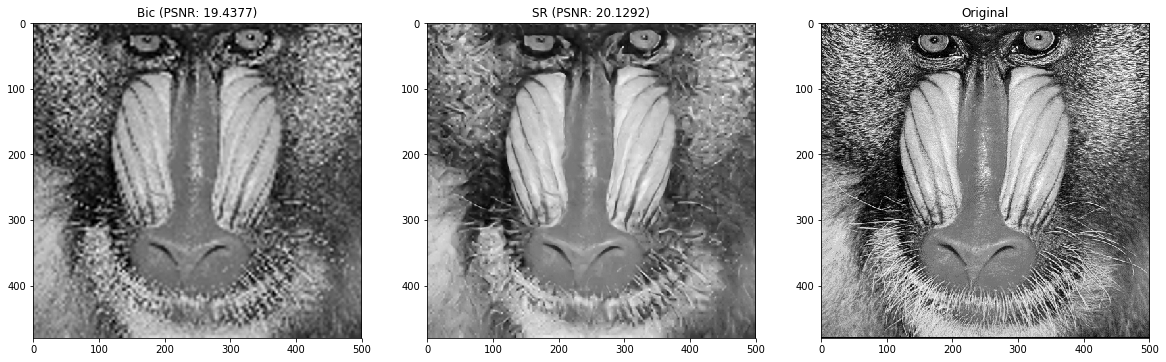

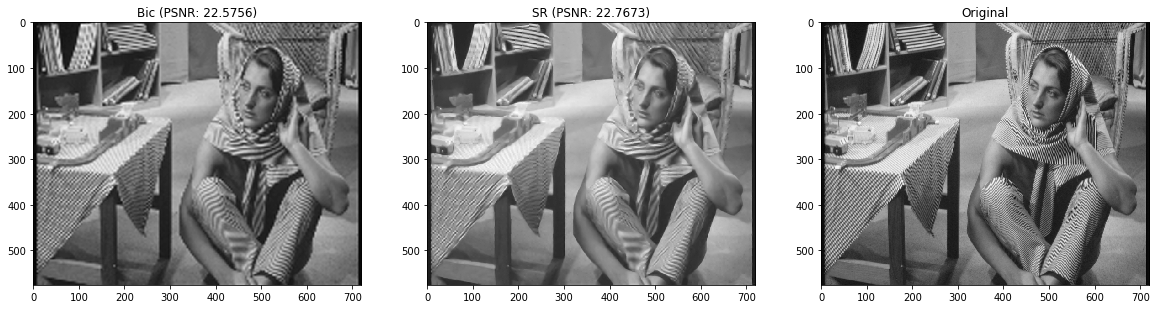

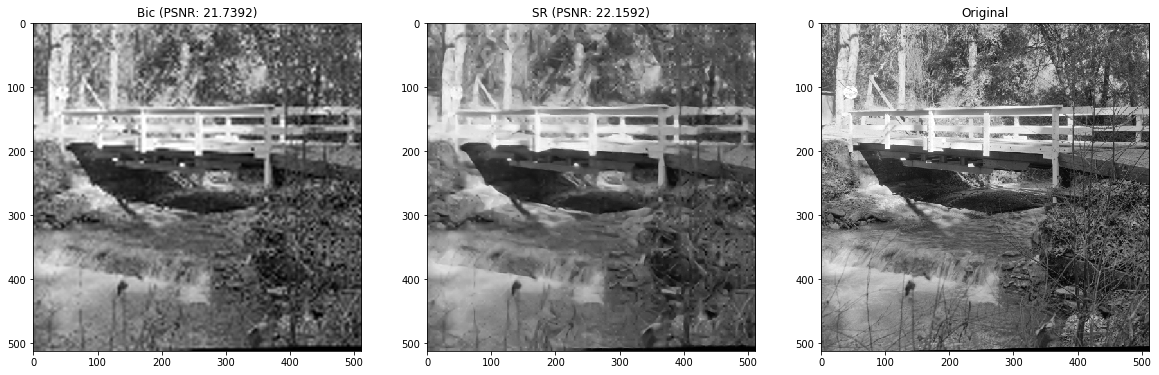

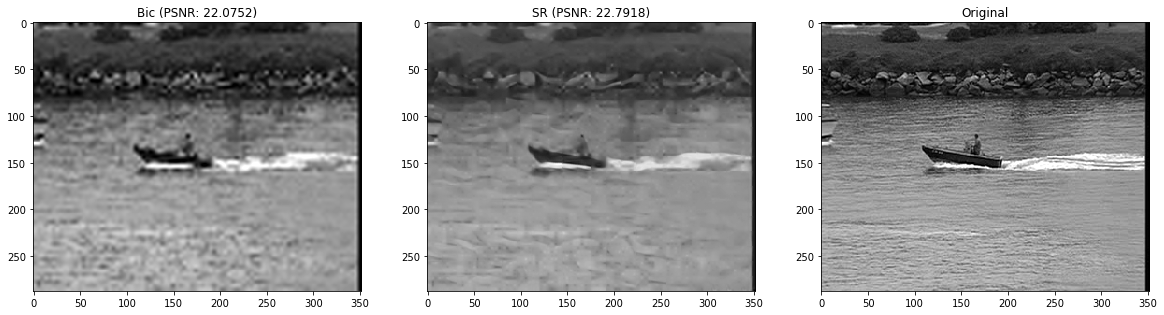

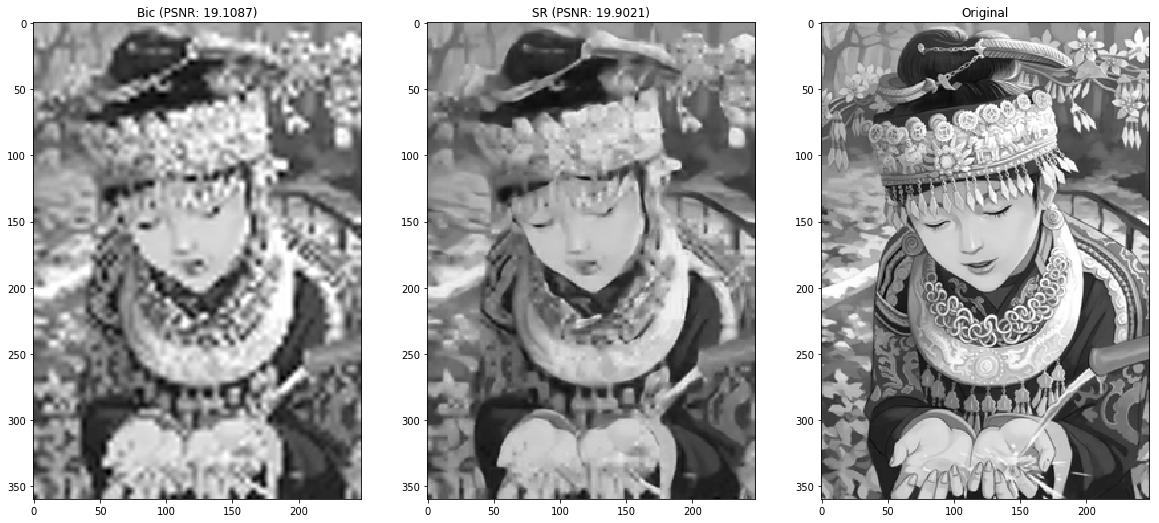

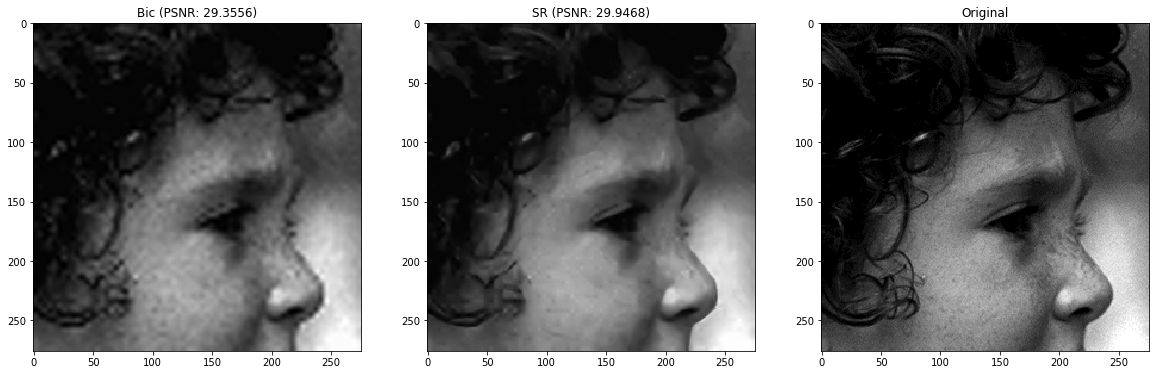

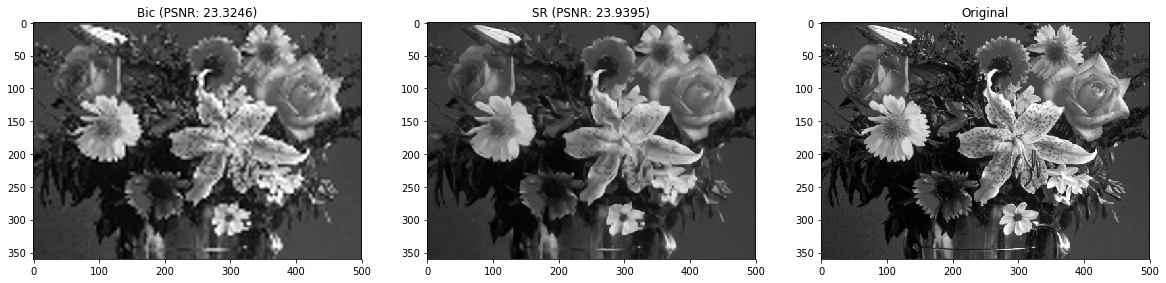

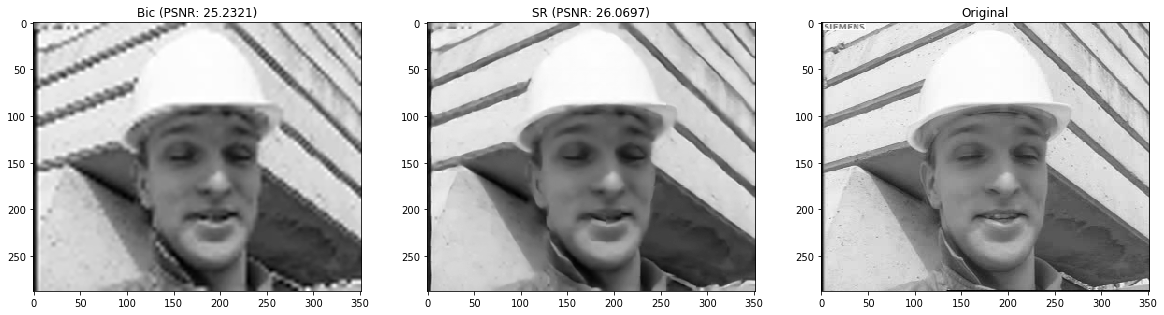

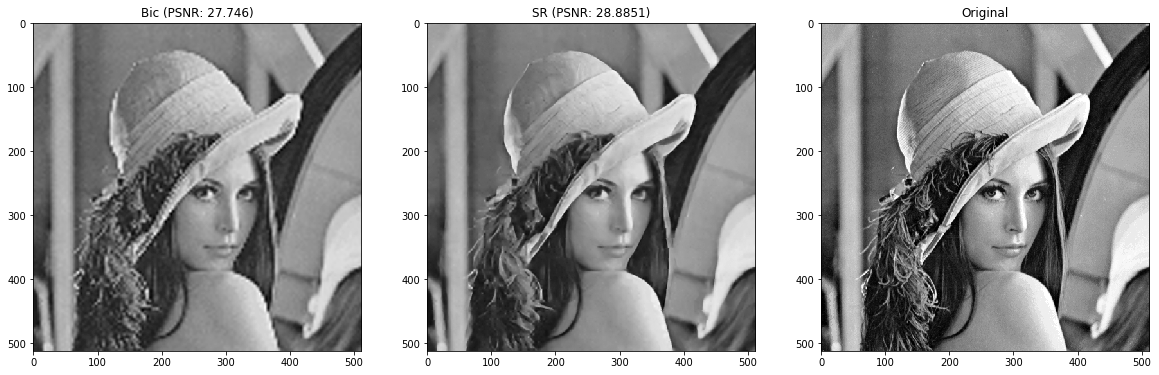

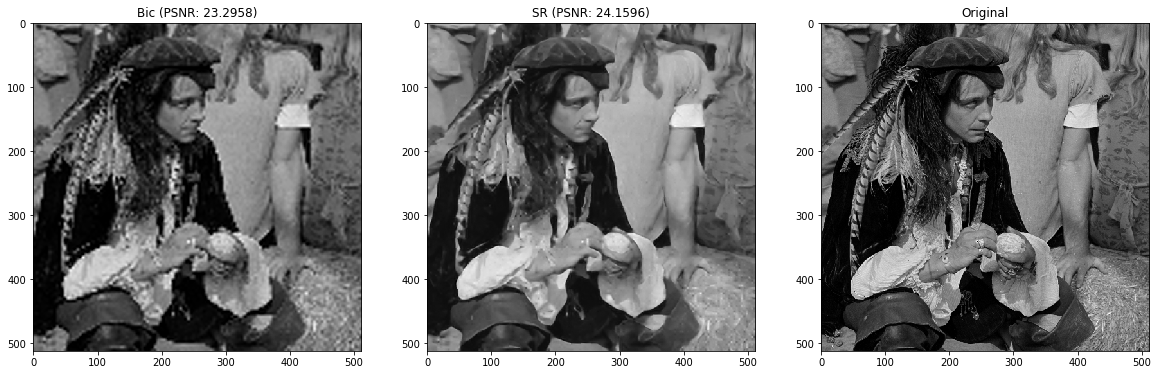

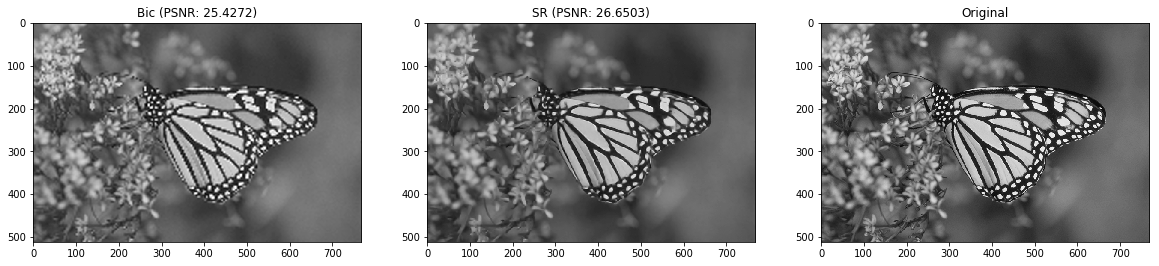

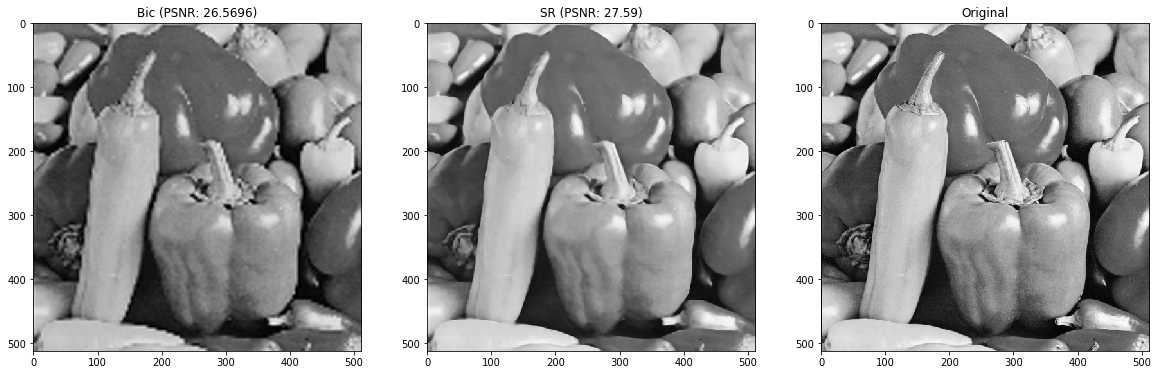

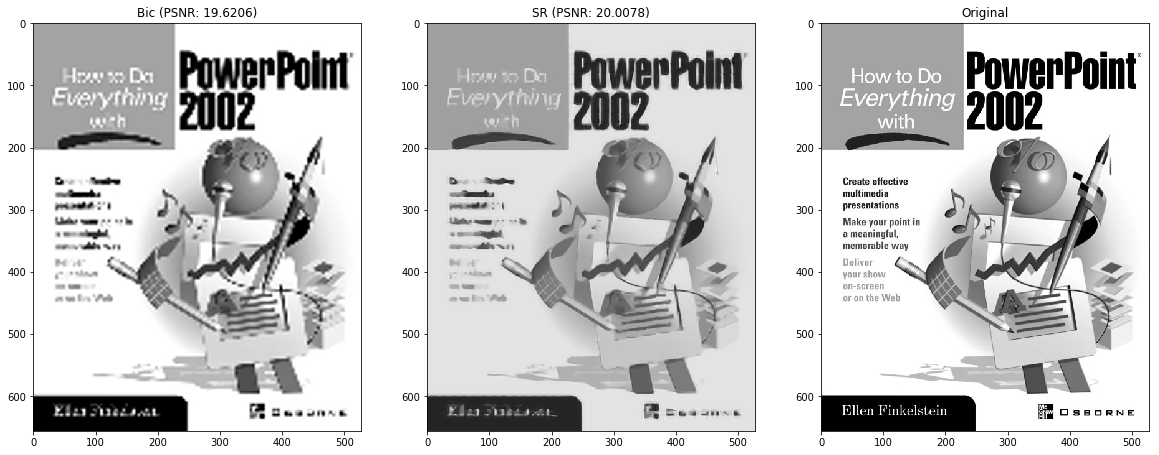

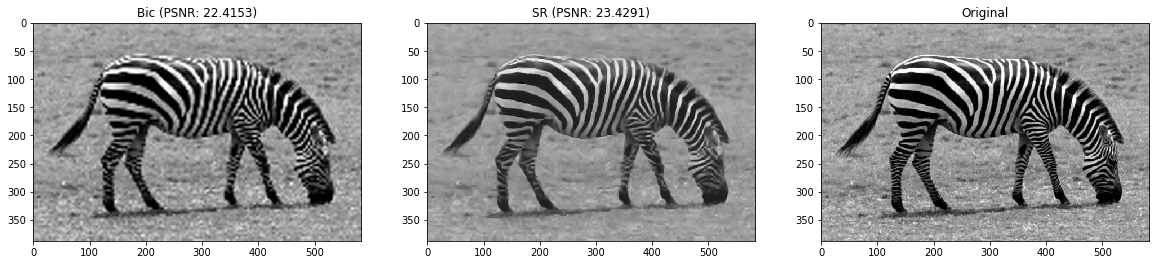

In [111]:
def calcMeasures(i):
    result=results[i]
    org=result[0].astype(float)
    bic=result[1].astype(float)
    sr=result[2].astype(float)
    
    psnr_bic=round(calcPSNR(org,bic),4)
    psnr_sr=round(calcPSNR(org,sr),4)
    
    ssim_bic=round(calcSSIM(org,bic),4)
    ssim_sr=round(calcSSIM(org,sr),4)
    
    mse_bic=round(calcMSE(org,bic),4)
    mse_sr=round(calcMSE(org,sr),4)

    print("Test image: ",i)
    print("")
    print("Bicubic")
    print("PSNR=",psnr_bic)
    print("SSIM=",ssim_bic)
    print("MSE=",mse_bic)
    print("")
    print("SR")
    print("PSNR=",psnr_sr)
    print("SSIM=",ssim_sr)
    print("MSE=",mse_sr)
    print("-------------")

for i in range(14):
    plot_results(i)

In [112]:
for i in range(14):
    calcMeasures(i)

('Test image: ', 0)

Bicubic
('PSNR=', 19.4377)
('SSIM=', 0.4544)
('MSE=', 745.9438)

SR
('PSNR=', 20.1292)
('SSIM=', 0.4658)
('MSE=', 636.1535)
-------------
('Test image: ', 1)

Bicubic
('PSNR=', 22.5756)
('SSIM=', 0.6817)
('MSE=', 362.179)

SR
('PSNR=', 22.7673)
('SSIM=', 0.6956)
('MSE=', 346.5343)
-------------
('Test image: ', 2)

Bicubic
('PSNR=', 21.7392)
('SSIM=', 0.5714)
('MSE=', 439.0974)

SR
('PSNR=', 22.1592)
('SSIM=', 0.5684)
('MSE=', 398.6245)
-------------
('Test image: ', 3)

Bicubic
('PSNR=', 22.0752)
('SSIM=', 0.4807)
('MSE=', 406.406)

SR
('PSNR=', 22.7918)
('SSIM=', 0.5223)
('MSE=', 344.5906)
-------------
('Test image: ', 4)

Bicubic
('PSNR=', 19.1087)
('SSIM=', 0.6139)
('MSE=', 804.6492)

SR
('PSNR=', 19.9021)
('SSIM=', 0.6372)
('MSE=', 670.2995)
-------------
('Test image: ', 5)

Bicubic
('PSNR=', 29.3556)
('SSIM=', 0.7235)
('MSE=', 76.0184)

SR
('PSNR=', 29.9468)
('SSIM=', 0.741)
('MSE=', 66.3444)
-------------
('Test image: ', 6)

Bicubic
('PSNR=', 23.3246)
('S